# Visualization - Interactive reconstructions

This notebook loads previously trained models and allows for reconstructions interactively.
By manual choice of individual parameters of dimensions in $\boldsymbol{z} \in \mathbb{R}^d$ the user can specify the properties of the sample to be reconstructed.

In [1]:
# Defines the background color of the widget. Only needed for something that is not white
color_bg = 'white'

In [2]:
# This mode allows for more fluent updates
%matplotlib widget

In [3]:
import json
import os
from glob import glob
from pathlib import Path
from attrdict import AttrDict
from matplotlib import pyplot as plt
import numpy as np
import pickle
import imageio

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import ipywidgets as widgets

from ipywidgets import interactive, fixed

In [5]:
def get_size_after_con2D(dim_in = (640,2360), padding = [0,0], dilation=[1,1], kernel_size=[5,5],stride =[1,1]):
    if type(padding) == int:  padding = [padding,padding]
    if type(dilation) == int:  dilation = [dilation,dilation]
    if type(kernel_size) == int:  kernel_size = [kernel_size,kernel_size]
    if type(stride) == int:  stride = [stride,stride]
    
    if padding == 'same':
        assert stride == 1, 'padding = same only valid for strides = 1'
        padding = [np.floor(kernel_size[0]/2.0), np.floor(kernel_size[1]/2.0)]
        
    dim0 = int((dim_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    dim1 = int((dim_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    return (dim0,dim1)


def get_size_after_pooling2D(dim_in = (640,2360), padding = [0,0], dilation=[1,1], kernel_size=[5,5],stride =[1,1]):
    
    if padding == 'same':
        assert stride in [1,[1,1]], 'padding = same only valid for strides = 1'
        padding = [np.floor(kernel_size[0]/2.0), np.floor(kernel_size[1]/2.0)]
    
    if type(padding) == int:  padding = [padding,padding]
    if type(dilation) == int:  dilation = [dilation,dilation]
    if type(kernel_size) == int:  kernel_size = [kernel_size,kernel_size]
    if type(stride) == int:  stride = [stride,stride]
        
    
    
    dim0 = int((dim_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0]-1)-1)/stride[0] +1)
    dim1 = int((dim_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1]-1)-1)/stride[1] +1)
    
    return (dim0,dim1)




class Conv2d_encoder(nn.Module):
    
    
    def __init__(self, 
                 input_dim= (640,2360), 
                 train = True,
                 device = 'cpu',
                 activations='mish', 
                 conv_sizes_encoder = [5,5,5], 
                 conv_nr_encoder = [1,8,16,32], 
                 conv_strides_encoder = 1,
                 pooling_kernel_size = [3,3,3],
                 pooling_stride = [3,3,3],             
                 ful_cn_nodes_encoder = [-1,500,24],
                 dropout_encoder = -1,
                 batch_norm = False):
                 
        super().__init__()
        self.latent_dims = int(ful_cn_nodes_encoder[-1]/2.)

        ## all this is to determine the dimension after all convolutional and pooling layers     
        dim = input_dim
        padding = 0# 'same' not supported by decoder
        self.pooling_dims = []
        self.conv_dims = [] #they are needed for transpose convs
        
        if type(conv_strides_encoder) == int:
            conv_strides_encoder = [conv_strides_encoder for _ in conv_sizes_encoder]
        
        padding = 0
        for i in range(len(conv_sizes_encoder)):
            self.conv_dims.append([dim[0],dim[1]])
            dim = get_size_after_con2D(
                dim_in = dim,
                padding = padding,
                kernel_size = conv_sizes_encoder[i],
                stride = conv_strides_encoder[i],
                )
            if len(pooling_kernel_size) >0:
                self.pooling_dims.append([dim[0],dim[1]])
                dim = get_size_after_pooling2D(
                    dim_in = dim,
                    padding =0,
                    kernel_size = pooling_kernel_size[i],
                    stride = pooling_stride[i],
                    )
                    
        self.last_dim = dim     
        ##now we have our dim.
        
        
        if ful_cn_nodes_encoder[0] == -1:
            ful_cn_nodes_encoder[0] = self.last_dim[0]*self.last_dim[1]*conv_nr_encoder[-1] 
            
            
        conv_nr = conv_nr_encoder    
        conv_sizes = conv_sizes_encoder
        ful_cn_nodes = ful_cn_nodes_encoder
        
        layer_con = [torch.nn.Conv2d(
            in_channels=conv_nr[i],      
            out_channels = conv_nr[i+1],
            kernel_size = conv_sizes[i],
            stride =conv_strides_encoder[i],
            padding = padding) for i in range(len(conv_sizes))]
        self.layer_con = nn.ModuleList(layer_con)
        
        
        if len(pooling_kernel_size) >0:
            self.pooling = True
            layer_pool = [torch.nn.MaxPool2d(
                    kernel_size=pks, 
                    stride=ps) for pks, ps in zip(pooling_kernel_size,pooling_stride)]
            self.layer_pool = nn.ModuleList(layer_pool)
        else:
            self.pooling =False
            self.layer_pool = [[] for _ in self.layer_con]
            

        if dropout_encoder > 0 :
            self.use_dropout = True
            layer_dropout = [nn.Dropout(p=dropout_encoder) for _ in zip(conv_sizes)]
            self.layer_dropout = nn.ModuleList(layer_dropout)
            
        else:
            self.use_dropout = False
            self.layer_dropout = [[] for _ in self.layer_con]
        
        if batch_norm:
            layer_norm = [nn.BatchNorm2d(conv_nr[i+1]) for i in range(len(conv_sizes))]
            self.layer_norm = nn.ModuleList(layer_norm)
            self.use_batchnorm = True
        else:
            self.use_batchnorm = False
            self.layer_norm = [[] for _ in self.layer_con]
            
        
        layer_fc = [nn.Linear(ful_cn_nodes[i],ful_cn_nodes[i+1]) for i in range(len(ful_cn_nodes)-1)  ]
        self.layer_fc = nn.ModuleList(layer_fc)
    
        
        if activations == 'mish':
            self.activations_con = [F.mish for _ in conv_sizes]
            self.activations_fc = [F.mish for _ in ful_cn_nodes[:-2]]
            activation_strings = ['mish' for _ in range(len(conv_sizes)+len(ful_cn_nodes)-2)]
            
            
        if activations == 'relu':
            self.activations_con = [F.relu for _ in conv_sizes]
            self.activations_fc = [F.relu for _ in ful_cn_nodes[:-2]]
            activation_strings = ['relu' for _ in range(len(conv_sizes)+len(ful_cn_nodes)-2)]
            
        
        self.N = torch.distributions.Normal(0, 1)
        if device == 'cuda':
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    

    def forward(self, x):
        batch,input_dim0,input_dim1 = x.shape
        x = x.view(batch,1,input_dim0,input_dim1)
        
        

        for activations, layer,pool,dropout,batchnorm in zip(self.activations_con, self.layer_con, self.layer_pool, self.layer_dropout, self.layer_norm):
            x = activations(layer(x)) 
            
            if self.use_dropout:
                x = dropout(x)
            
            if self.pooling: 
                x = pool(x)
                
            if self.use_batchnorm:
                x = batchnorm(x)

        
        
        x = x.view(batch,-1)
        
        for activations, layer in zip(self.activations_fc, self.layer_fc):
            x = activations(layer(x))
            

        x = self.layer_fc[-1](x)
        
        x = x.view(batch, 2, -1) 
    
        if self.train:
            mu = x[:, 0, :] 
            logvar = x[:, 1, :] 
            sigma =  torch.exp(0.5*logvar)       
            z = mu + sigma*self.N.sample(mu.shape)      
            self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   
        else:
            z = torch.empty(x.shape[0],2,self.latent_dims)
            z[:,0,:] = x[:, 0, :] 
            z[:,1,:] = torch.exp(0.5*x[:, 1, :] )

        return z
        

class Conv2d_decoder(nn.Module):
    
    def __init__(self, 
                 last_dim, #2d
                 activations='mish', 
                 conv_sizes_decoder = [5,5,5], 
                 conv_nr_decoder = [1,8,16,32], 
                 conv_strides_decoder = 1,          
                 pooling_dims = [3,3,3],
                 conv_dims = [3,3,3],
                 pooling_mode = 'nearest',
                 ful_cn_nodes_decoder = [-1,500,24],
                 dropout_decoder = -1,
                 conv_type = 'Transpose'):
                 
        super().__init__()    
        
        self.last_dim = last_dim
        self.conv_dims = conv_dims
    
        ful_cn_nodes = ful_cn_nodes_decoder
        layer_fc = [nn.Linear(ful_cn_nodes[i],ful_cn_nodes[i+1]) for i in range(len(ful_cn_nodes)-1)  ]
        self.layer_fc = nn.ModuleList(layer_fc)     
        
        
        conv_nr = conv_nr_decoder
        self.conv_nr = conv_nr
        conv_sizes = conv_sizes_decoder
        
        if type(conv_strides_decoder) == int:
            conv_strides_decoder = [conv_strides_decoder for _ in conv_sizes]
            
        padding = 0
        
        if conv_type == 'Transpose':
            convFunction = torch.nn.ConvTranspose2d
        else:
            convFunction = torch.nn.Conv2d
        
        layer_con = [convFunction(
            in_channels=conv_nr[i],      
            out_channels = conv_nr[i+1],
            kernel_size = conv_sizes[i],
            stride = conv_strides_decoder[i],
            padding = padding) for i in range(len(conv_sizes))]
        
        self.layer_con = nn.ModuleList(layer_con)
        
        
        self.upsample = False
        if len(pooling_dims)> 0:
            self.upsample = True
            layer_up = [torch.nn.Upsample(size=tuple(pd), mode = pooling_mode ) for pd in pooling_dims]
            self.layer_up = nn.ModuleList(layer_up)  
            
        else: self.layer_up = [[] for _ in self.layer_con]
        
        if dropout_decoder > 0 :
            self.use_dropout = True
            layer_dropout = [nn.Dropout(p=dropout_decoder) for _ in zip(conv_sizes)]
            self.layer_dropout = nn.ModuleList(layer_dropout)
            
        else:
            self.use_dropout = False
            self.layer_dropout = [[] for _ in self.layer_con]
        
        
        if activations == 'mish':
            self.activations_con = [F.mish for _ in conv_sizes]
            self.activations_fc = [F.mish for _ in ful_cn_nodes[:-1]]
            activation_strings = ['mish' for _ in range(len(conv_sizes)+len(ful_cn_nodes)-1)]
            
            
        if activations == 'relu':
            self.activations_con = [F.relu for _ in conv_sizes]
            self.activations_fc = [F.relu for _ in ful_cn_nodes[:-1]]
            activation_strings = ['relu' for _ in range(len(conv_sizes)+len(ful_cn_nodes)-1)]
            

        
        self.decoder_args = {
            'convolution layer decoder': conv_nr,
            'filter sizes decoder':conv_sizes,
            'fully_connected decoder': ful_cn_nodes,
            'encoder_activations decoder': activation_strings,
            }

    def forward(self, x):
        batch, _ = x.shape
        
        for activations, layer in zip(self.activations_fc, self.layer_fc):
            x = activations(layer(x))
        
        
        x = x.view(batch,self.conv_nr[0],self.last_dim[0], self.last_dim[1]) #-1 is imdim
        
        for activations, layer, upsam,cs,dropout in zip(self.activations_con, self.layer_con, self.layer_up, self.conv_dims, self.layer_dropout):
            if self.upsample:
                x = upsam(x)
             
            if self.use_dropout:
                x = dropout(x)    
                
            x = activations(layer(x, output_size = cs)) 

       # x = x.view(batch, -1)
        #assert x.shape[0] == 3, 'output dim has to be batch, imdim0,imdim1'
        torch.squeeze(x,1)
        return x      
        
        
    def load(self, path = 'testpath'):
        self.decoder.load_state_dict(torch.load(path +'_decoder',map_location=torch.device(self.device)))
        
def get_model(id_string, rootpath,device):
    file  = open(rootpath+id_string+'/paramdict.pkl','rb')
    model_dict = pickle.load(file)
    modeltype = Conv2d_autoencoder
    kwargs = model_dict['kwargs']
    kwargs.pop('__class__',None)
    kwargs.pop('self',None)
    if device == 'cpu':
        kwargs['device'] = 'cpu'
    model = modeltype(**kwargs)
    
    return model


class Conv2d_autoencoder(nn.Module):

    def __init__(self, 
                 input_dim= (640,2360), 
                 device = 'cpu',
                 train = True,
                 activations='mish', 
                 conv_sizes_encoder = [5,5,5], 
                 conv_nr_encoder = [1,8,16,32], 
                 conv_strides_encoder = 1,
                 pooling_kernel_size = [],
                 pooling_stride = [],       
                 interpolation_mode ='nearest',
                 ful_cn_nodes_encoder = [-1,500,24],
                 dropout_encoder = -1,
                 dropout_decoder = -1,
                 batch_norm = False,
                 conv_type_decoder = 'Transpose'):
                 
        super().__init__()
        self.kwargs = locals()
        self.kwargs.pop('__class__',None)
        self.kwargs.pop('self',None)
        self.latent_dims = int(ful_cn_nodes_encoder[-1]/2)
        self.device = device
        
       # assert len(pooling_kernel_size)<=0: 'pooling is not implemented yet, as upsampling is not trivial'
        #gib die dem encoder
        
        self.encoder = Conv2d_encoder(
                 input_dim= input_dim, 
                 train = train,
                 device = device,
                 activations=activations, 
                 conv_sizes_encoder = conv_sizes_encoder, 
                 conv_nr_encoder = conv_nr_encoder, 
                 conv_strides_encoder = conv_strides_encoder,
                 pooling_kernel_size = pooling_kernel_size,
                 pooling_stride = pooling_stride,             
                 ful_cn_nodes_encoder = ful_cn_nodes_encoder,
                 dropout_encoder= dropout_encoder,
                 batch_norm = batch_norm)
        
        # bilde die Argumente für den Decoder (inklusive last dim)
        last_dim_encoder = self.encoder.last_dim
        if type(conv_sizes_encoder) == list :
            conv_sizes_decoder = conv_sizes_encoder[::-1]
        else:
            conv_sizes_decoder = conv_sizes_encoder
        if type(conv_nr_encoder) == list :
            conv_nr_decoder =  conv_nr_encoder[::-1]
        else: 
            conv_nr_decoder =  conv_nr_encoder
        if type(conv_strides_encoder) == list :
            conv_strides_decoder = conv_strides_encoder[::-1]
        else:
            conv_strides_decoder = conv_strides_encoder
        
        
        
        ful_cn_nodes_decoder = ful_cn_nodes_encoder[::-1]
        ful_cn_nodes_decoder[0] = int(ful_cn_nodes_decoder[0]/2)
        ful_cn_nodes_decoder[-1] = int(self.encoder.last_dim[0]*self.encoder.last_dim[1]*conv_nr_encoder[-1])
        
        pooling_dims = self.encoder.pooling_dims[::-1] #may cause problems due to rounding problems
        conv_dims = self.encoder.conv_dims[::-1]    
        
        self.decoder = Conv2d_decoder(
                 last_dim = last_dim_encoder, #2d
                 activations=activations, 
                 conv_sizes_decoder = conv_sizes_decoder, 
                 conv_nr_decoder = conv_nr_decoder, 
                 conv_strides_decoder = conv_strides_decoder,          
                 pooling_dims = pooling_dims,
                 conv_dims = conv_dims,
                 pooling_mode = interpolation_mode,
                 ful_cn_nodes_decoder = ful_cn_nodes_decoder,
                 dropout_decoder = dropout_decoder,
                 conv_type = conv_type_decoder)
         
        self.decoder = self.decoder.to(device)
        


    
    
    def forward(self,x):
        z = self.encoder(x)
        return self.decoder(z)
        
    def load(self, path = 'testpath'):
        self.decoder.load_state_dict(torch.load(path +'_decoder',map_location=torch.device(self.device)))
        self.encoder.load_state_dict(torch.load(path +'_encoder',map_location=torch.device(self.device)))
            

In [6]:
def get_trained_model(rand_id, rootpath='./model/', epoch = -1,device='cpu'): #medelnam is folder name (sim/meas)
    if epoch <0:
        saveepochs = [int(savestring.split('_')[-2]) for savestring in glob(rootpath+str(rand_id)+'/'+'*_decoder')]
        epoch = max(saveepochs)
        
    savepoint = rootpath+'{:s}/{:s}_{:d}'.format(rand_id,rand_id,epoch)
    savedir = rootpath+str(rand_id)+'/'
    
    if os.path.exists(savedir+'paramdict.pkl'):
        model = get_model(rand_id, rootpath,device=device)
        model.load(savepoint)
    else:
        print('No saved model parameters found')
        
    return model

In [7]:
def center_images(images,boundaries =[70,170]):
    '''use center of mass to center images this function does not remove not centerable images anymore! use centerable_images to filter '''
    nr_images = images.shape[0]
    imshape0 = images.shape[1]
    imshape1 = images.shape[2]
    low_bound = boundaries[0]
    high_bound = boundaries[1]
    
    one_d = np.sum(np.array(images), axis = 1) 
    one_d -= np.min(one_d,axis=1)[0]
    x_axis = np.arange(one_d.shape[1])
    cog = np.sum(x_axis*one_d,axis=1)/np.sum(one_d,axis=1)
    
    
    shift = cog - imshape1/2 ##ungenau.. aber vermutlich erst mal ausreichend?
    shift = shift.astype('int')
   # filtered_shift = shift[(cog > low_bound) & (cog<high_bound) ]
  #  num_outlayers = shift.shape[0]-filtered_shift.shape[0]
  #  images = images[(cog > low_bound) & (cog<high_bound) ]
    
    new_images = torch.zeros((nr_images,imshape0, imshape1))
    
    for i,shift in enumerate(shift):
        if shift < 0:
            new_images[i,:,-shift:] = images[i,:,:shift]
        elif shift >0: 
            new_images[i,:,:-shift] = images[i,:,shift:] 
        else: 
            new_images[i]= images[i]
    
    return new_images

In [8]:
def build_z_dict(model_name,data_path, nr_images = 10): #name of .npz (sim/meas))
    with torch.no_grad():
        if model_name == 'meas': normv = 255.
        if model_name == 'sim': normv = 605.
        
        full_path = os.path.join('images',data_path)
        images = torch.tensor(np.load(full_path)/normv)[:nr_images]
        images = center_images(images,boundaries = [70,170])
        model = get_trained_model(model_name, f'{config_dir}/')
        encoder = model.encoder
        encoder.train = False
        z_nodes = encoder(images)
        z_dict = {i : [list(np.array(z_nodes[i,0,:])),images[i]] for i in range(images.shape[0])}  
        z_dict['no image']= 'No image'
    return z_dict



In [9]:
def sort_by_generation(x):
    _, generation, _ = Path(x).stem.split('_')
    return int(generation)

In [10]:
config_dir =  './model/'
#config_files = sorted(glob(f'{config_dir}/*/*.json'))
config_files = [os.path.join(config_dir,'pc{:03d}'.format(i),'pc{:03d}.json'.format(i)) for i in range(142,144)]

config_files = [glob(config_dir + 'sim/*.json')[0],glob(config_dir + 'meas/*.json')[0]]

model_names = [
    'sim',
    'meas'
]
model_infos = [
    AttrDict(json.load(open(c))).info
    for c in config_files
]
model_decoders = [
    sorted(glob(f'{config_dir}/{n}/{n}_*_decoder'), key=sort_by_generation)
    for n in model_names
]
model_z_dims = [
    AttrDict(json.load(open(c))).fit.model_param.ful_cn_nodes_encoder[-1] // 2
    for c in config_files
]

In [11]:
model_dict = {
    f"{model_names[idx]}": {
        'config_file': config_files[idx],
        'model_name': model_names[idx],
        'model_info': model_infos[idx],
        'model_z_dim': model_z_dims[idx],
        'model_decoder': model_decoders[idx],
    }
    for idx in range(len(config_files))
}

In [12]:
z_dict_flash = build_z_dict('meas','valSet_flash.npy' )
z_dict_sim = build_z_dict('sim','rand_sim.npy' )

In [13]:
def select_model(model_dict):
    model_dict = AttrDict(model_dict)

    model = get_trained_model(model_dict.model_name, f'{config_dir}/')
    decoder = model.decoder
    z_dim = decoder.layer_fc[0].in_features
    y_dim = decoder.layer_up[1].size
    assert z_dim == model_dict.model_z_dim
    
    return decoder, z_dim, y_dim

In [14]:
def handle_slider_change(change):
    values = [alpha.value for alpha in z_sliders]
    z = torch.tensor(values)[None, :]
    try:
        y = decoder(z).detach().cpu()
    except Exception as e:
        caption.value = (str(e))
        return
    y = y.reshape(y.shape[-2:])
    if y.shape[-1] == 200:
        y = np.rot90(y)
    im.set_data(y)
    #caption.value = (y.shape)
    
    fig.canvas.draw_idle()

In [15]:
def handle_slider_change2(change):
    values = [alpha.value for alpha in z_sliders2]
    z = torch.tensor(values)[None, :]
    try:
        y = decoder2(z).detach().cpu()
    except Exception as e:
        caption.value = (str(e))
        return
    y = y.reshape(y.shape[-2:])
    if y.shape[-1] == 200:
        y = np.rot90(y)
    im2.set_data(y)
    #caption.value = (y.shape)
    
    if np.array_equal(values,[2.5]*10):
        im2.set_data(imageio.imread('./easteregg/importantImage2.png'))
    
    fig2.canvas.draw_idle()

In [16]:
def reset_sliders(change):
    for widget in z_sliders:
        widget.value = widget.default_value
    for widget in z_sliders2:
        widget.value = widget.default_value
        
        
def load_image_flash(imageindex):
    if type(imageindex) == str:
        for widget in z_sliders2:
            widget.value = widget.default_value  
        
    else:
        for widget,z_value in zip(z_sliders2,imageindex[0]):
            widget.value = z_value       
        im2_im.set_data(imageindex[1])
        
        
def load_image_sim(imageindex):
    if type(imageindex) == str:
        for widget in z_sliders2:
            widget.value = widget.default_value  
    
    else:
        for widget,z_value in zip(z_sliders,imageindex[0]):
            widget.value = z_value
        im_im.set_data(np.rot90(imageindex[1]))

## Model trained on simulated  data

|||
|--|--|
|not used| z0, z3, z4|
|energy at start and end of bunch|z1, z8|
|lasing|z2|
|energy of bunch|z6|
|duration of lasing|z7|
|temporal profile of electron bunch|z5, z9|



interactive(children=(Dropdown(description='imageindex', options={0: [[0.010495504, -0.07214847, 0.028249003, …

Label(value='')

Button(description='Reset', style=ButtonStyle())

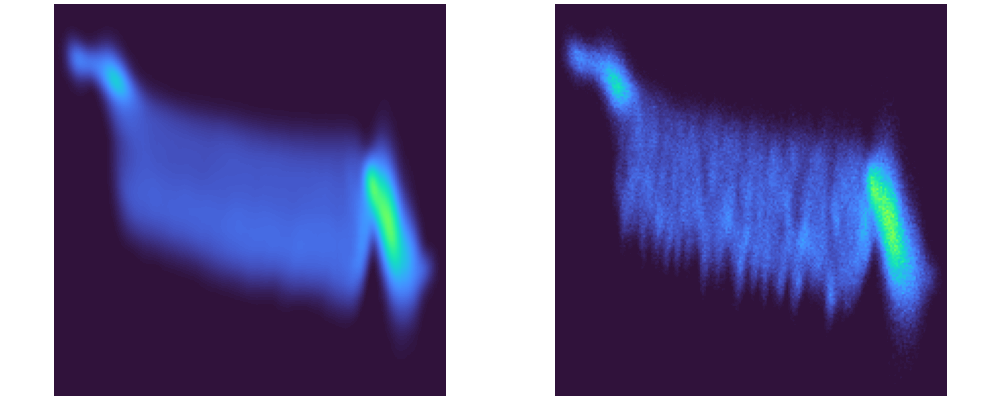

In [17]:
decoder, z_dim, y_dim = select_model(model_dict['sim'])
z_sliders = [
    widgets.FloatSlider(min=-5, max=5, step=1e-3, description=f'$z_{{{i}}}$', orientation='vertical')
    for i in range(z_dim)
    
]
for widget in z_sliders:
    widget.observe(handle_slider_change, names='value')
    widget.default_value = 0
    

     
model_name = 'sim'

plt.close(f"Neural reconstruction using decoder part of model '{model_name}'")

fig = plt.figure(f"Neural reconstruction using decoder part of model '{model_name}'", dpi=100, constrained_layout=True, figsize = (10,4)) #, figsize=y_dim)
fig.set_facecolor(color_bg)
ax = fig.add_subplot(1, 2, 1)
ax.axis('off')
im = ax.imshow(np.random.random(y_dim), cmap='turbo', vmax =1.1)
im.set_data(np.zeros(y_dim))

ax_im = fig.add_subplot(1, 2, 2)
ax_im.axis('off')
im_im = ax_im.imshow(np.random.random(y_dim), cmap='turbo', vmax =1.1)
im_im.set_data(np.zeros(y_dim))


reset_button = widgets.Button(description= 'Reset')    
reset_button.on_click(reset_sliders)


selected_image = interactive(load_image_sim, imageindex=z_dict_sim)
display(selected_image)


ui = widgets.HBox(z_sliders)
caption = widgets.Label(value='')
display(ui, caption,reset_button)
print('')
handle_slider_change(None)
load_image_sim(z_dict_sim[0])


## Model trained on real world  data

|||
|--|--|
|lasing| z9|
|len of electron bunch/ lasing position| z1, z7|
|temporal profile/ chirp| z4,z6|
|bunching due to accelerator| z0, z2, z3, z5 , z8|


interactive(children=(Dropdown(description='imageindex', options={0: [[0.6603512, -0.32944056, -0.1381588, 0.5…

Button(description='Reset', style=ButtonStyle())

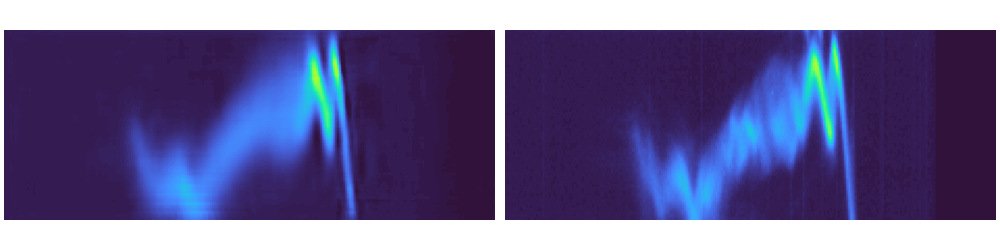

In [18]:
decoder2, z_dim2, y_dim2 = select_model(model_dict['meas'])
z_sliders2 = [
    widgets.FloatSlider(min=-5, max=5, step=1e-3, description=f'$z_{{{i}}}$', orientation='vertical')
    for i in range(z_dim2)
]
for widget in z_sliders2:
    widget.observe(handle_slider_change2, names='value')
    widget.default_value = 0
    
    
    

model_name = 'meas'



plt.close(f"Neural reconstruction using decoder part of model '{model_name}'")
fig2 = plt.figure(f"Neural reconstruction using decoder part of model '{model_name}'", dpi=100, constrained_layout=True, figsize=(10,2.5)) #, figsize=y_dim)
fig2.set_facecolor(color_bg)
ax2 = fig2.add_subplot(1, 2, 1)
ax2.axis('off')
im2 = ax2.imshow(np.random.random(y_dim2), cmap='turbo', vmax = 1.1, aspect = 1.5)
im2.set_data(np.zeros(y_dim2))


ax2_im = fig2.add_subplot(1, 2, 2)
ax2_im.axis('off')
im2_im = ax2_im.imshow(np.random.random(y_dim2), cmap='turbo', vmax = 1.1, aspect = 1.5)
im2_im.set_data(np.zeros(y_dim2))


selected_image = interactive(load_image_flash, imageindex=z_dict_flash)
display(selected_image)    





reset_button = widgets.Button(description= 'Reset')    
reset_button.on_click(reset_sliders)

ui2 = widgets.HBox(z_sliders2)
caption2 = widgets.Label(value='')
display(ui2, reset_button)
print('')
handle_slider_change2(None)
load_image_flash(z_dict_flash[0])

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>